In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

C:\Users\omalv\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # n,3,64,64
            nn.Conv2d(channels_img,features_d,stride=2,padding=1,kernel_size=4),
            nn.LeakyReLU(),
            # n,64,32,32
            self._block(features_d,features_d*2,stride=2,padding=1,kernel_size=4),
            # n,128,16,16
            self._block(features_d*2,features_d*4,stride=2,padding=1,kernel_size=4),
            # n,256,8,8
            self._block(features_d*4,features_d*8,stride=2,padding=1,kernel_size=4),
            # n,512,4,4
            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0),
        )
        
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self,x):
        return self.disc(x)

In [35]:
class Generator(nn.Module):
    def __init__(self,channels_noise,channels_img,features_g):
        super().__init__()
        self.gen = nn.Sequential(
            # n,channels_noise,1,1
            self._block(channels_noise,features_g*16,kernel_size=4,stride=1,padding=0),
            # n,1024,4,4
            self._block(features_g*16,features_g*8,kernel_size=4,stride=2,padding=1),
            # n,512,8,8
            self._block(features_g*8,features_g*4,kernel_size=4,stride=2,padding=1),
            # n,256,16,16
            self._block(features_g*4,features_g*2,kernel_size=4,stride=2,padding=1),
            # n,128,32,32
            nn.ConvTranspose2d(features_g*2,channels_img,kernel_size=4,stride=2,padding=1),
            nn.Tanh(),
        )
        
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels,affine=True),
            nn.ReLU(),
        )

    def forward(self,x):
        return self.gen(x)

In [42]:
def gradient_penalty(critic,real,fake,device="cpu"):
    batch_size,c,h,w = real.shape
    eps = torch.rand((batch_size,1,1,1)).repeat(1,c,h,w).to(device)
    interpolated_images = real * eps + fake * (1-eps)
    scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs = interpolated_images,
        outputs=scores,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0],-1)
    gradient_norm = gradient.norm(2,dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    return gradient_penalty

In [48]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
lr = 1e-4
batch_size = 64
num_epochs = 10
critic_iter = 5
gradient_lambda = 10
critic = Discriminator(1,64).to(device)
gen = Generator(100,1,64).to(device)
fixed_noise= torch.randn((batch_size,100,1,1)).to(device)
clip_constraint = 0.01
t = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(1)], [0.5 for _ in range(1)]
        ),
    ]
)

dataset = datasets.MNIST(
    root="dataset/", train=True, transform=t, download=True
)

loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
opt_critic = optim.Adam(critic.parameters(),lr=lr)
opt_gen = optim.Adam(gen.parameters(),lr=lr)
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0

In [55]:
for epoch in range(30):
    for batch_idx,(real,_) in enumerate(loader):
        real = real.to(device)   
        batch_size = real.shape[0]
        for _ in range(critic_iter):
            noise = torch.randn(batch_size,100,1,1).to(device)
            fake = gen(noise)
            critic_real = critic(real).view(-1)
            critic_fake = critic(fake).view(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) \
            + gradient_penalty(critic,real,fake,device=device) * gradient_lambda
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        output = critic(fake).view(-1)
        lossG = -torch.mean(output)
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {lossG:.4f}"
            )

#             with torch.no_grad():
#                 fake = gen(fixed_noise)
#                 # take out (up to) 32 examples
#                 img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
#                 img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

#                 writer_real.add_image("Real", img_grid_real, global_step=step)
#                 writer_fake.add_image("Fake", img_grid_fake, global_step=step)

#             step += 1

Epoch [0/10] Batch 0/938                   Loss D: -10.2704, loss G: 36.8605
Epoch [0/10] Batch 100/938                   Loss D: -9.3208, loss G: 33.0564
Epoch [0/10] Batch 200/938                   Loss D: -7.4853, loss G: 35.5335


KeyboardInterrupt: 

In [45]:
import matplotlib.pyplot as plt

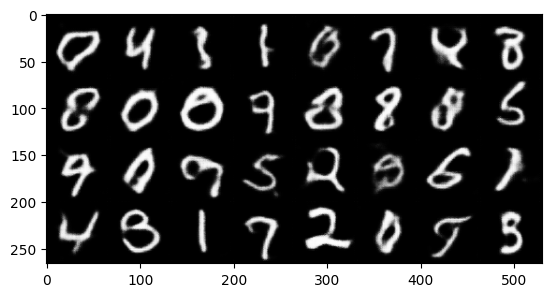

In [56]:
plt.imshow(torchvision.utils.make_grid(fake[:32], normalize=True).cpu().permute(1,2,0))